In [16]:
import sklearn
from sklearn.cluster import KMeans

import numpy as np

In [17]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [18]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

In [19]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [20]:
log_reg.score(X_test, y_test)

0.7581863979848866

In [21]:
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9093198992443325

In [23]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

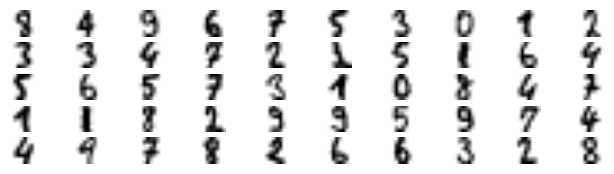

In [25]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')
plt.show()

In [26]:
y_representative_digits = np.array([
     8, 4, 9, 6, 7, 5, 3, 0, 1, 2,
     3, 3, 4, 7, 2, 1, 5, 1, 6, 4,
     5, 6, 5, 7, 3, 1, 0, 8, 4, 7, 
     1, 1, 8, 2, 9, 9, 5, 9, 7, 4, 
     4, 9, 7, 8, 2, 6, 6, 3, 2, 8
])

In [27]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8387909319899244

In [28]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [29]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [30]:
log_reg.score(X_test, y_test)

0.8589420654911839

In [31]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [32]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.8564231738035264

In [33]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

np.float64(0.9548148148148148)

# Reflection & Summary

In this activity we are basically walking through a Semi-Supervised Learning example:

* The baseline accuracy when we trained a logistic regression on 50 samples was: 0.76. This serves as the baseline: with very few labels, the model struggles to generalize.
* When we used all labeled points for the logistic regression the accuracy was 0.91. This represents the upper bound achievable with full supervised learning.

### Using KMeans to Select Representative Samples

Instead of labeling 50 random points, we use KMeans to find 50 cluster centers and then choose the closest real data point to each center. These become our representative samples. After manually labeling just these 50 representative points, training logistic regression on them yields accuracy of 0.84. This is a meaningful improvement over the random‑50 baseline because the selected points are more informative and cover the dataset more evenly.

### Label propagation:

To leverage the unlabeled data, we propagate the 50 manual labels to the entire training set:

* Every training point inherits the label of the cluster it belongs to.
* Training logistic regression on this fully "pseudo‑labeled" dataset achieves 0.86 accuracy. This surpasses both the random 50 baseline and the representative 50 model, showing the benefit of using unlabeled data.

### Confidence Filtering:
Not all propagated labels are equally reliable. To improve label quality:
* For each cluster, we keep only the points that are closest to the cluster center (within the 99th percentile of closeness).
* These points are considered high‑confidence pseudo‑labels.
* Training on this filtered subset yields accuracy similar to the full propagation approach (around ~0.856), but with a key advantage, the high‑confidence propagated labels are 95% correct when compared to the true labels.

This confirms that cluster‑based propagation is most trustworthy near the cluster centers and less reliable for outliers.